# Tech Challenge 02 - Prevendo dados da Bolsa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

* o modelo com o storytelling, desde a captura do dado até a entrega do modelo
* justificar a técnica utilizada
* atingir uma acuracidade adequada (acima de 70%)

### 01 - Importando bibliotecas

In [157]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf

#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          
from statsmodels.tsa.stattools import acf, pacf       
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA           
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Encontrando os Picos de Sazonalidade
from scipy.signal import find_peaks

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

#### 01.1 - Fazendo Upload dos dados

In [91]:
import yfinance as yf

# Especifique o símbolo da IBOVESPA (^BVSP) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2010-01-01'
end_date = '2024-01-08'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [92]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,68587.0,70081.0,68587.0,70045.0,70045.0,1655400
1,2010-01-05,70046.0,70595.0,69928.0,70240.0,70240.0,1984200
2,2010-01-06,70237.0,70937.0,70016.0,70729.0,70729.0,2243600
3,2010-01-07,70723.0,70723.0,70045.0,70451.0,70451.0,1555000
4,2010-01-08,70455.0,70766.0,70158.0,70263.0,70263.0,1634400


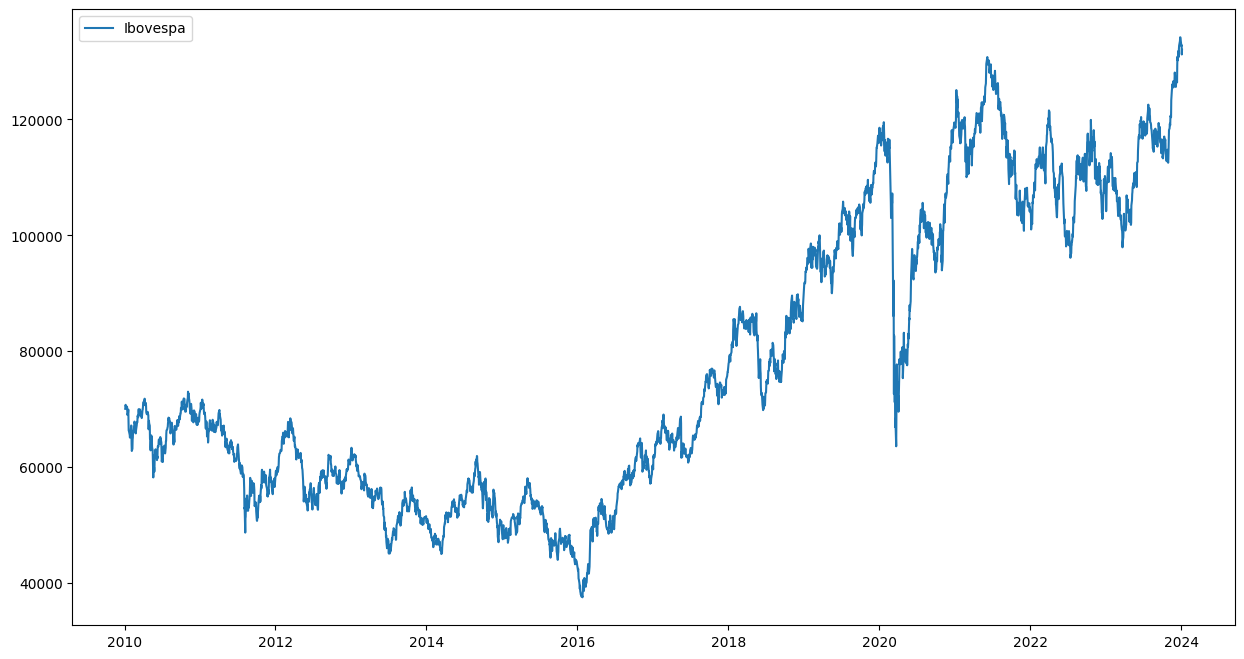

In [93]:
plt.figure(figsize = (15,8))
plt.plot(df['Date'], df['Close'], label='Ibovespa')

plt.legend(loc='best')
plt.show()

#### 01.2 - Analisando a Decomposição da Série Temporal

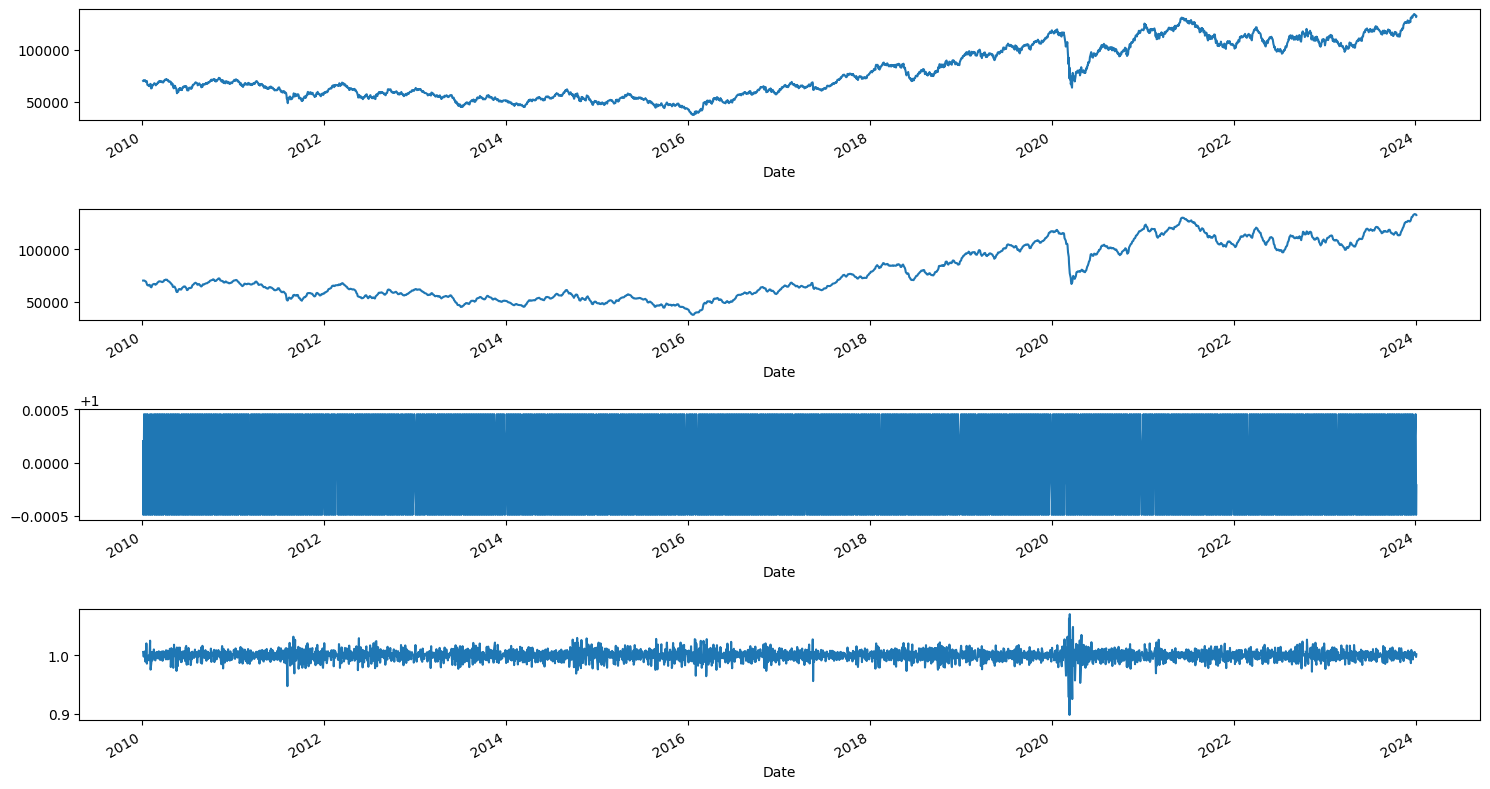

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) 
df_limpo = df_limpo.set_index('Date')                                      

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) 
seasonplot.trend.plot(ax=ax2)    
seasonplot.seasonal.plot(ax=ax3) 
seasonplot.resid.plot(ax=ax4)    
plt.tight_layout()

### 02 - Testando Modelos

#### 02.1 - Trabalhando com Estacionáridade (M.M.A., ARIMA E SARIMA)

#### 02.1.1 - Média Móvel com janela de prévisão de 10 dias e 20 dias

In [95]:
df = pd.DataFrame(df[['Close', 'Date']])
df.set_index('Date', inplace=True)
df['MA_window_10'] = df['Close'].rolling(10).mean().shift()
df['MA_window_20'] = df['Close'].rolling(20).mean().shift()

In [96]:
df.head(21)

,Close,MA_window_10,MA_window_20
Date,,,
2010-01-04,70045.0,NaN,NaN
2010-01-05,70240.0,NaN,NaN
2010-01-06,70729.0,NaN,NaN
2010-01-07,70451.0,NaN,NaN
2010-01-08,70263.0,NaN,NaN
2010-01-11,70433.0,NaN,NaN
2010-01-12,70076.0,NaN,NaN
2010-01-13,70385.0,NaN,NaN
2010-01-14,69801.0,NaN,NaN


##### Visualizando o resultado:

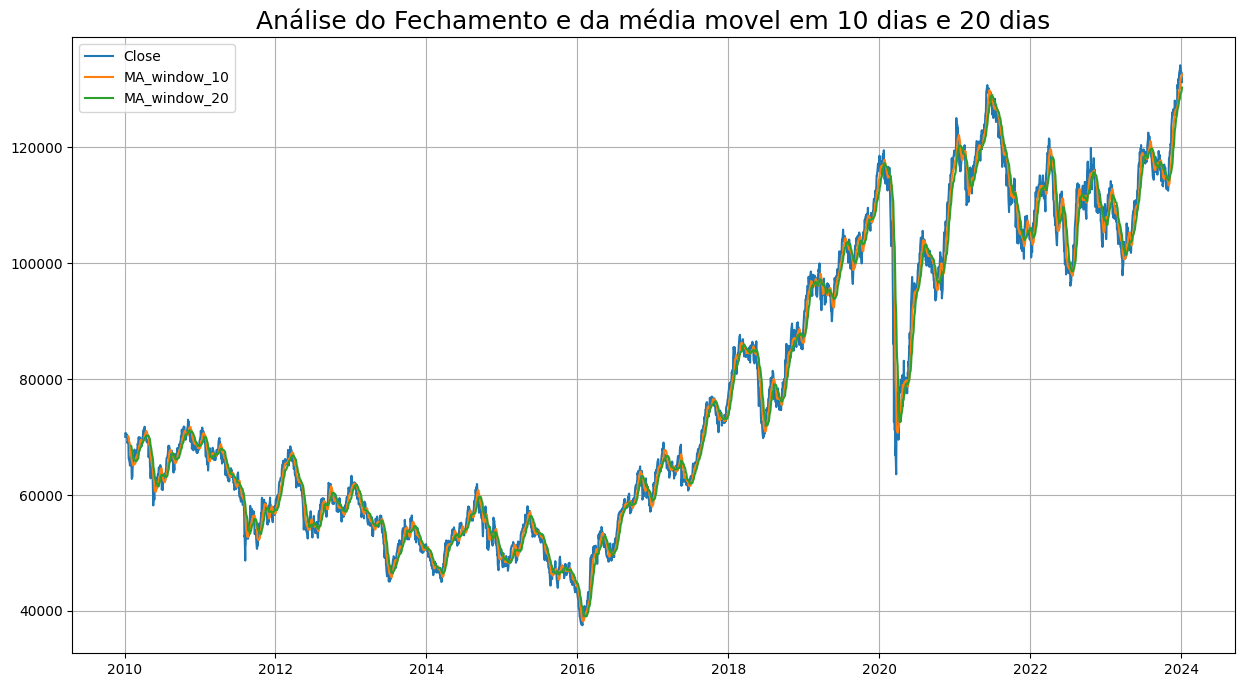

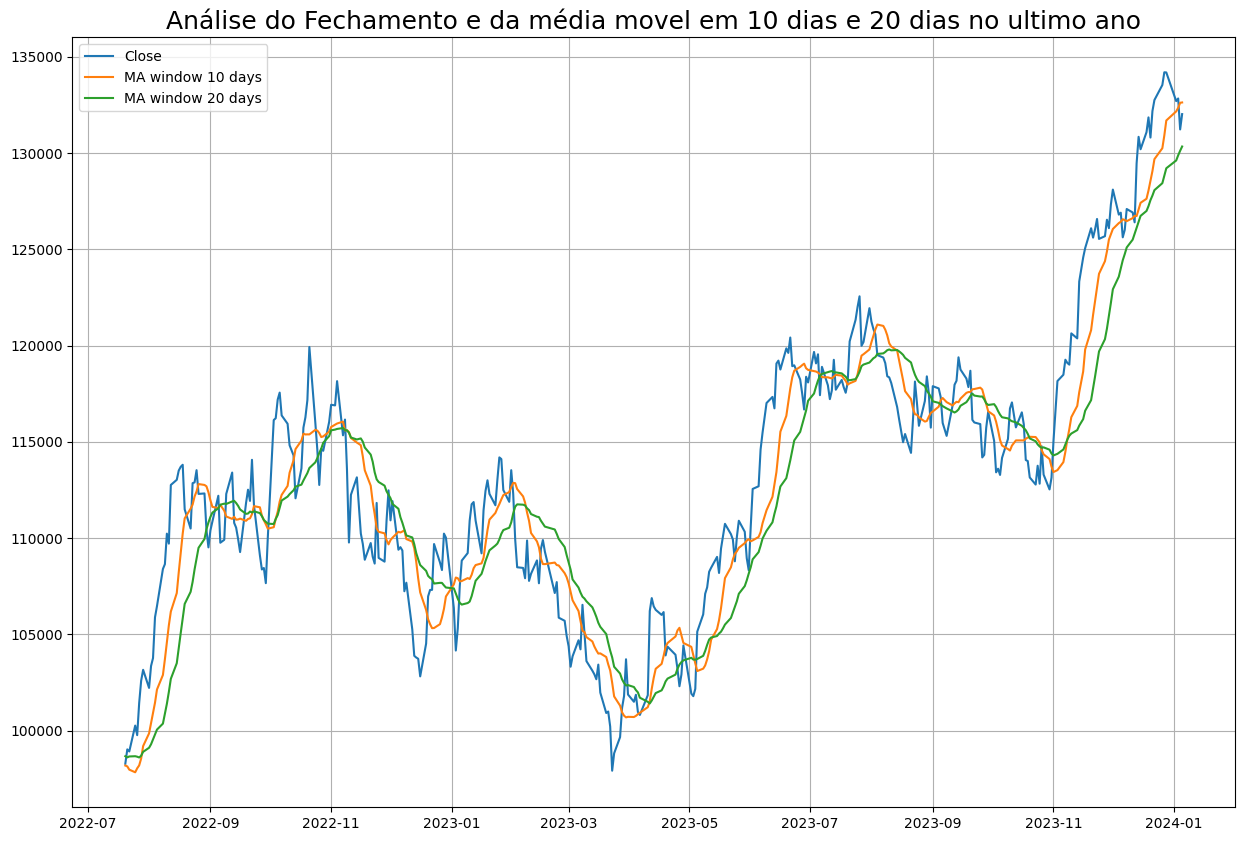

In [97]:
# Analisando todo o período com a média móvel
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df['Close'], label = 'Close')
plt.plot(df['MA_window_10'], label = 'MA_window_10')
plt.plot(df['MA_window_20'], label = 'MA_window_20')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias',
          loc='center',  fontsize=18)
plt.show()

# Destacando o período aos ultimo ano

limit = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias no ultimo ano',
          loc='center',  fontsize=18)
plt.show()




##### Prevendo "N" dias com base na MMA (Média Móvel Aritmética)

Nessa parte trabalharemos com a média movél de 10 dias e 20 dias, criando uma janela de tempo para ambas de modo a observar seu movimento de predição.

In [98]:
df['MA_window_10_forward_10'] = np.NaN
df['MA_window_20_forward_20'] = np.NaN

#Função para criar a jalena de período
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [99]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


In [100]:
window_size = 20
forward_days = 20

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_20_forward_20'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_20_forward_20')] = mean


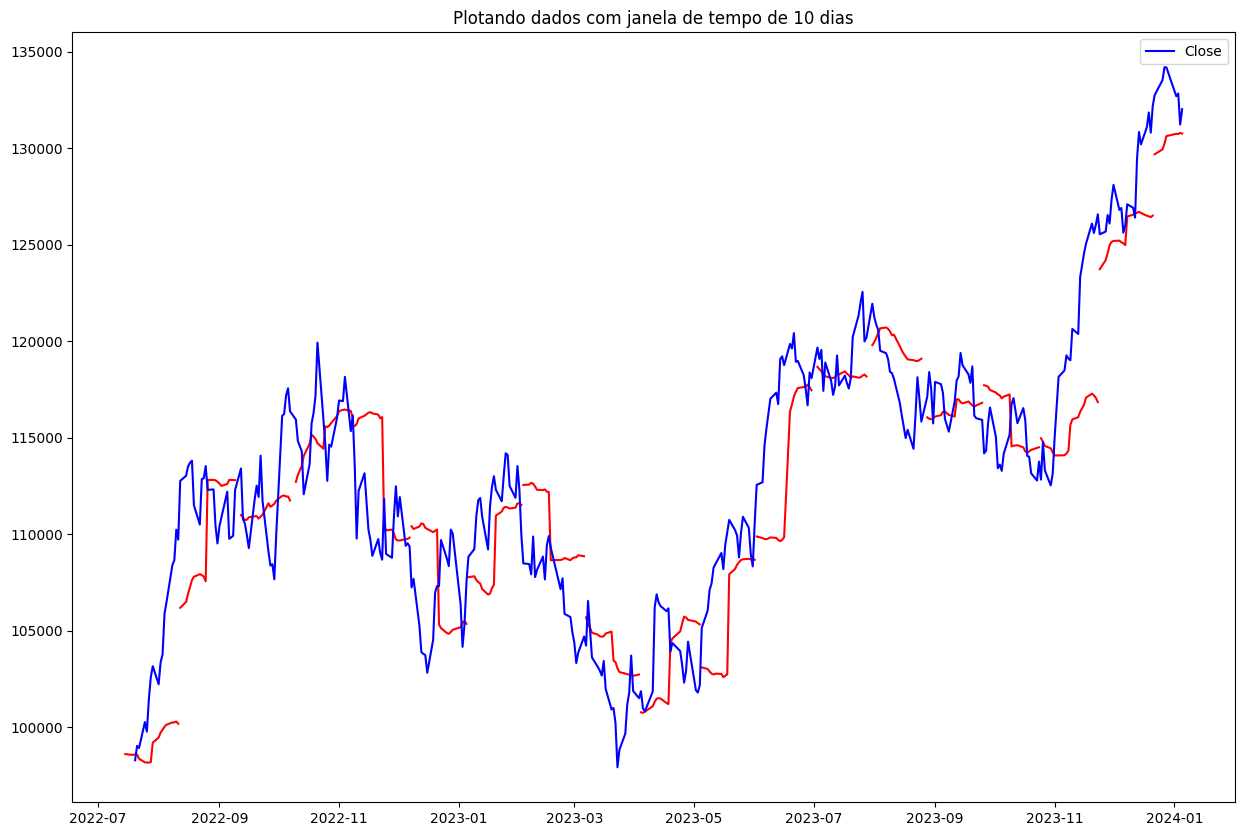

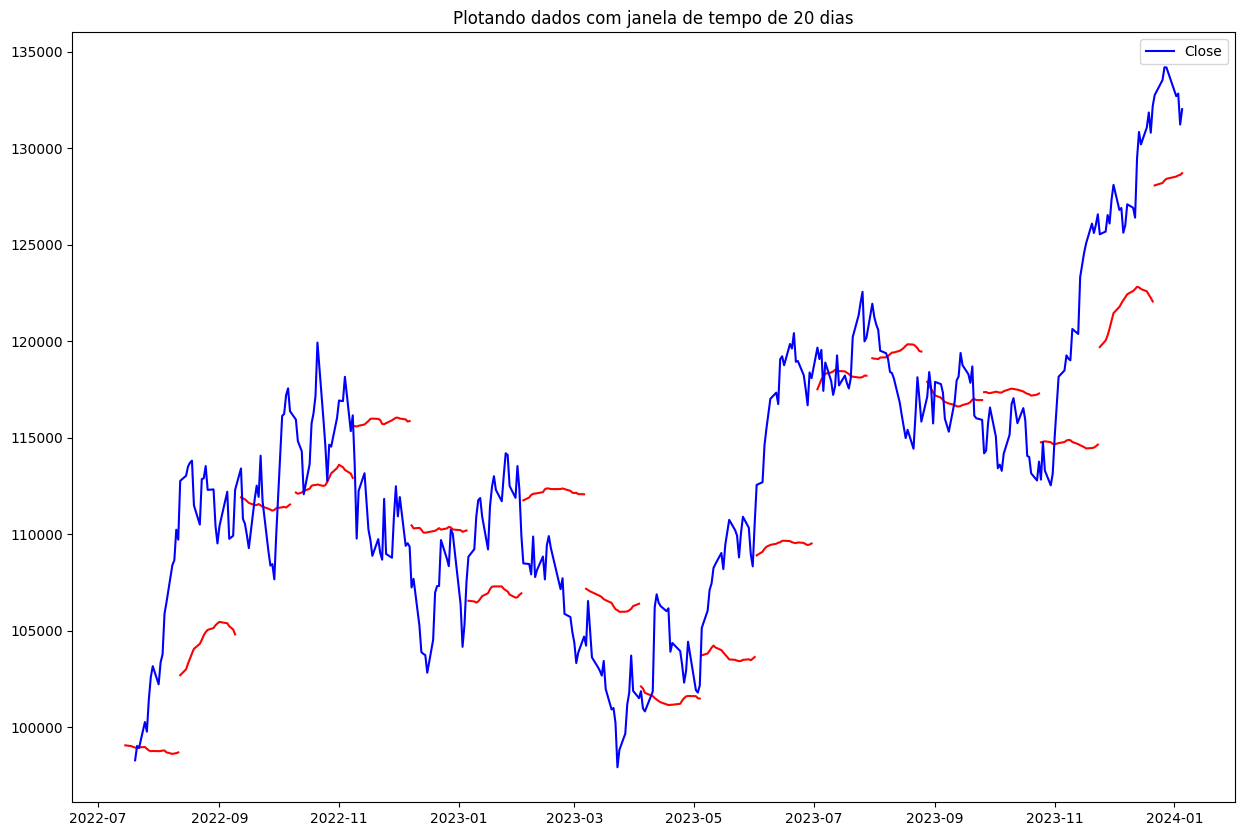

In [101]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc='best')
plt.show()

#Plotando dados com janela de 20 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 20 dias')
plt.legend(loc='best')
plt.show()

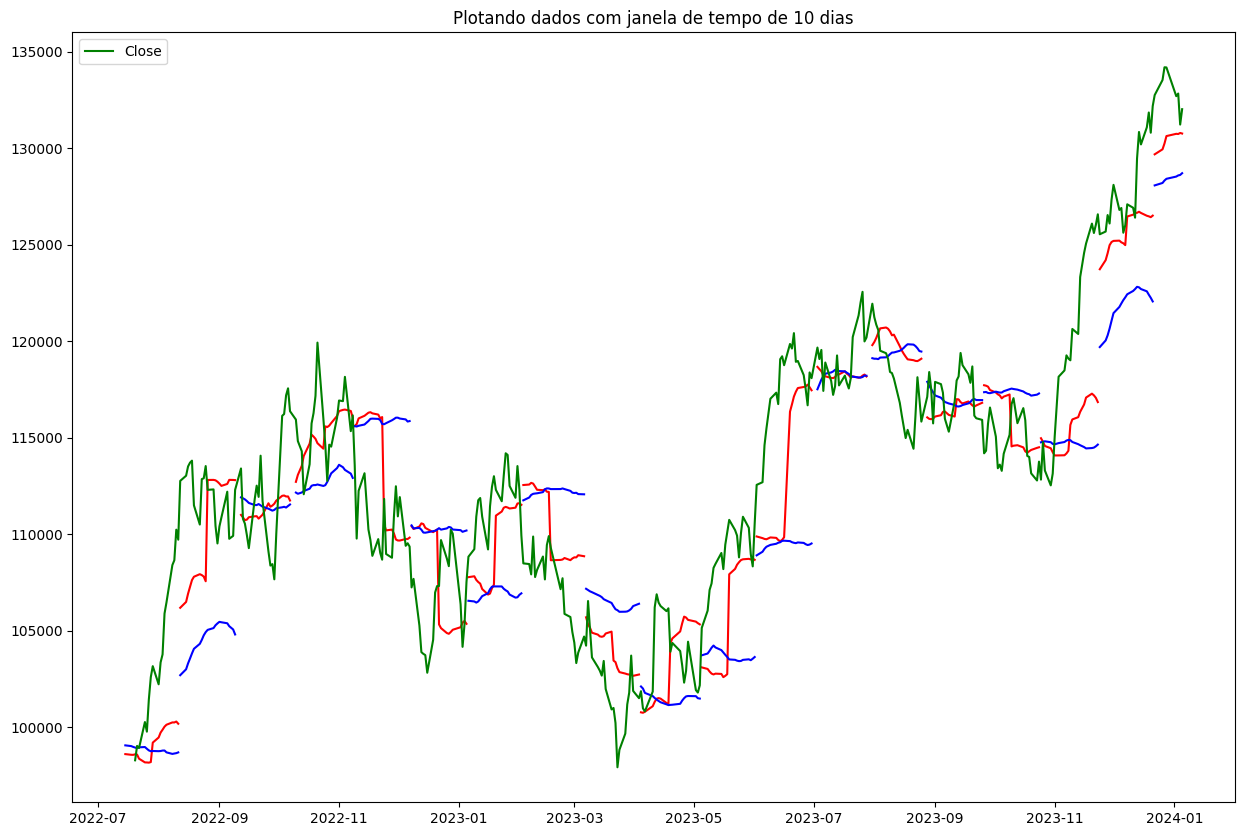

In [102]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='b')


plt.plot(df['Close'][-limit:], color='g', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc=2)
plt.show()

#### 02.1.2 - Módelo ARIMA E SARIMA

#### 02.1.2.1 - ARIMA

##### Teste de Dickey-Fuller - Verificando a Estacionariedade da Série

In [106]:
# Teste de estacionariedade (ADF Test)

adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1].astype(int)}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificação se a série é estacionária
alpha = 0.05  # Limiar de significância
if adf_result[1] < alpha:
    print('A série é estacionária. Hipótese nula rejeitada.')
else:
    print('A série não é estacionária. Falha em rejeitar a hipótese nula.')

ADF Statistic: -0.7925922201042586
p-value: 0
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -0.7925922201042586
Valor-p: 0.8212883680823235
Valores Críticos:
   1%: -3.4322435658885047
   5%: -2.8623766691169186
   10%: -2.567215374070993
A série não é estacionária. Falha em rejeitar a hipótese nula.


##### Teste de Dickey-Fuller - Transformando a Série em estacionária

In [117]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    adf_result = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    alpha = 0.05  # Limiar de significância
    if adf_result[1] < alpha:
        print('A série é estacionária. Hipótese nula rejeitada.')
    else:
        print('A série não é estacionária. Falha em rejeitar a hipótese nula.')
        print(f'Valor-p: {adf_result[1]}')
        print(f'Limiar de Significância (alpha): {alpha}')


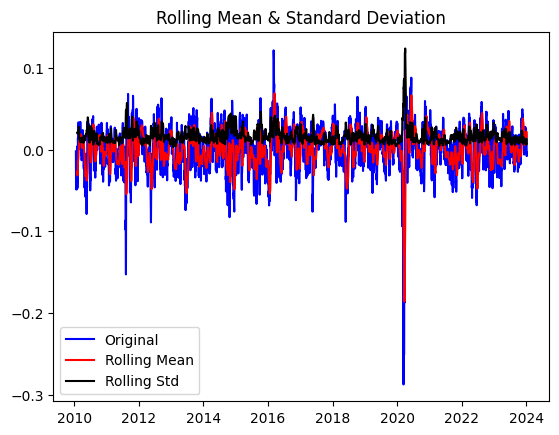

Results of Dickey Fuller Test:
Test Statistic                -1.520645e+01
p-value                        5.733744e-28
#Lags Used                     7.000000e+00
Number of Observations Used    3.449000e+03
Critical Value (1%)           -3.432247e+00
Critical Value (5%)           -2.862378e+00
Critical Value (10%)          -2.567216e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [118]:
# Log pela média móvel
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma

# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

# Subtraindo os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

test_stationarity(datasetLogScaleMinusMovingAverage)

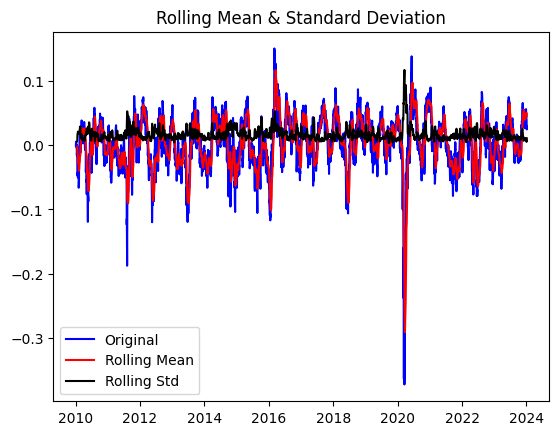

Results of Dickey Fuller Test:
Test Statistic                -8.837201e+00
p-value                        1.706415e-14
#Lags Used                     7.000000e+00
Number of Observations Used    3.460000e+03
Critical Value (1%)           -3.432241e+00
Critical Value (5%)           -2.862376e+00
Critical Value (10%)          -2.567215e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [119]:
# Decaimento Exponencial
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()

# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)


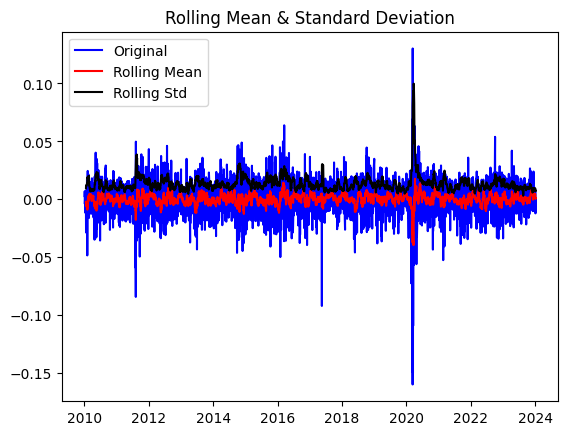

Results of Dickey Fuller Test:
Test Statistic                  -21.890113
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    3460.000000
Critical Value (1%)              -3.432241
Critical Value (5%)              -2.862376
Critical Value (10%)             -2.567215
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [120]:
# Diferenciação

datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


##### Teste de correlação parcial

O ACF toca zero pela primeira vez no atraso 1.
O PACF toca zero pela primeira vez no atraso 1.


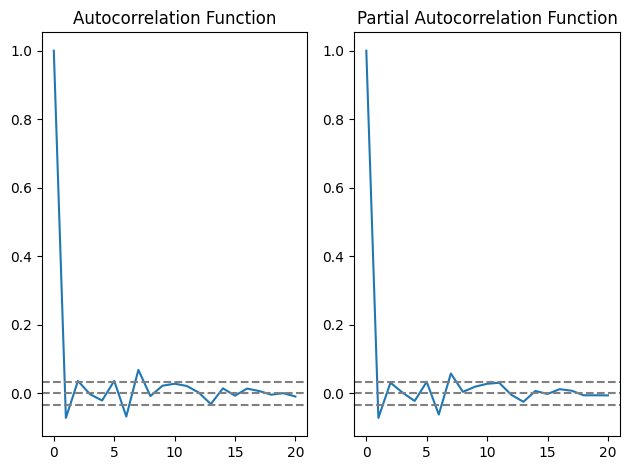

In [123]:
# Calcular ACF e PACF
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Encontrar o primeiro ponto em que ACF toca zero
zero_crossing_acf = next(i for i, value in enumerate(lag_acf) if value <= 0)

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

# Encontrar o primeiro ponto em que PACF toca zero
zero_crossing_pacf = next(i for i, value in enumerate(lag_pacf) if value <= 0)

# Imprimir os resultados
print(f'O ACF toca zero pela primeira vez no atraso {zero_crossing_acf}.')
print(f'O PACF toca zero pela primeira vez no atraso {zero_crossing_pacf}.')

plt.tight_layout()
plt.show()

##### Plotando o Arima e Avaliando o MAPE (Mean Absolute Percentage Error)

Plotting AR model
RSS: 0.8056
MAPE: 1084.54%


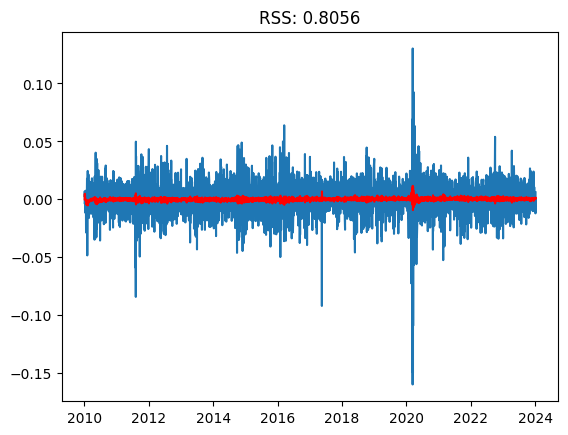

In [129]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(1,1,1))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')
print('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))


# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

#### 02.1.2.2 - SARIMA

O SARIMA, ou Seasonal AutoRegressive Integrated Moving Average, é uma extensão do modelo ARIMA para séries temporais que exibem sazonalidade. O acrônimo SARIMA representa "Seasonal ARIMA", indicando que o modelo incorpora componentes sazonais.

A estrutura do modelo SARIMA é definida por vários parâmetros, semelhantes ao ARIMA. A notação geral para um modelo SARIMA é SARIMA(p, d, q)(P, D, Q, s), onde:

p: Ordem AR (AutoRegressive) para a componente não sazonal.
d: Ordem de diferenciação para tornar a série temporal estacionária.
q: Ordem MA (Moving Average) para a componente não sazonal.
P: Ordem AR sazonal.
D: Ordem de diferenciação sazonal.
Q: Ordem MA sazonal.
s: Período sazonal.

##### Definindo parametros de Sazonalidade - P: Ordem AR sazonal.

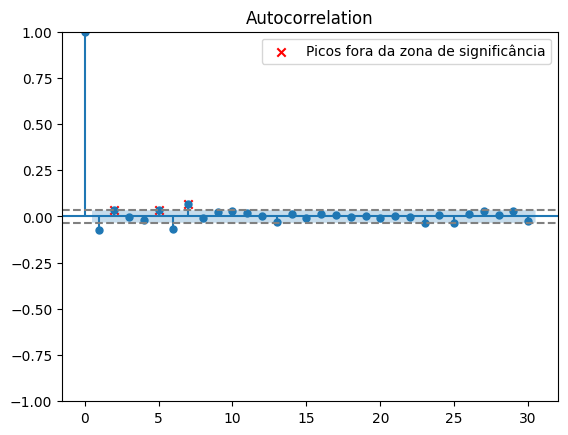

Número de pontos fora da zona de significância: 3


In [171]:
seasonal_lags = 30  # Ajuste conforme necessário

# Calcule as linhas de confiança
N = len(datasetLogDiffShifting)
limite_superior = 1.96 / np.sqrt(N)
limite_inferior = -1.96 / np.sqrt(N)

# Calcule o ACF
acf_values, _ = acf(datasetLogDiffShifting, fft=False, nlags=seasonal_lags, alpha=0.05)

# Encontre os picos
picos, _ = find_peaks(acf_values)

# Identifique os picos fora da zona de significância
picos_fora_da_zona = [pico for pico in picos if acf_values[pico] > limite_superior or acf_values[pico] < limite_inferior]

# Visualize os resultados
plot_acf(datasetLogDiffShifting, lags=seasonal_lags)
plt.scatter(picos_fora_da_zona, acf_values[picos_fora_da_zona], color='red', marker='x', label='Picos fora da zona de significância')
plt.axhline(y=limite_superior, linestyle='--', color='gray')
plt.axhline(y=limite_inferior, linestyle='--', color='gray')
plt.legend()
plt.show()

# Mostre quantos pontos estão fora da zona de significância
print(f'Número de pontos fora da zona de significância: {len(picos_fora_da_zona)}')


Quando você encontra picos fora da zona de significância após a diferenciação dos dados, isso sugere que a diferenciação ajudou a tornar a série temporal mais estacionária. Vamos entender o que isso significa:

Dados Originais sem Diferenciação (Possivelmente Não Estacionários):

Se não há picos significativos fora da zona de significância no gráfico de autocorrelação (ACF) dos dados originais, isso pode indicar que a série temporal original não exibe padrões claros de autocorrelação nas observações. Isso pode ser um sinal de não estacionariedade ou de uma tendência que precisa ser removida.
Dados Diferenciados (Possivelmente Estacionários):

Quando você diferencia os dados e encontra picos fora da zona de significância, isso sugere que a diferenciação ajudou a remover a tendência ou padrões não estacionários, tornando a série temporal mais estacionária. Picos significativos no ACF podem indicar presença de autocorrelação sazonal ou não sazonal.

##### Definindo parametros de Sazonalidade - D: Ordem de diferenciação sazonal.

Escolha a Ordem de Diferenciação Sazonal Adequada:

Observe os gráficos ACF e PACF para diferentes ordens de D. A ordem de diferenciação sazonal adequada geralmente é aquela que reduz as autocorrelações sazonais mais significativamente e não deixa padrões aparentes.

Escolha a ordem de D que resulta em uma série temporal diferenciada sazonalmente mais estacionária, indicada por uma redução nas correlações significativas.

A interpretação dos gráficos ACF e PACF é fundamental, e você pode experimentar com diferentes ordens de D até encontrar uma que pareça apropriada.

Ordem de Diferenciação Sazonal (D): 1, Pontos fora da zona de significância (ACF): 12
Ordem de Diferenciação Sazonal (D): 1, Pontos fora da zona de significância (PACF): 10


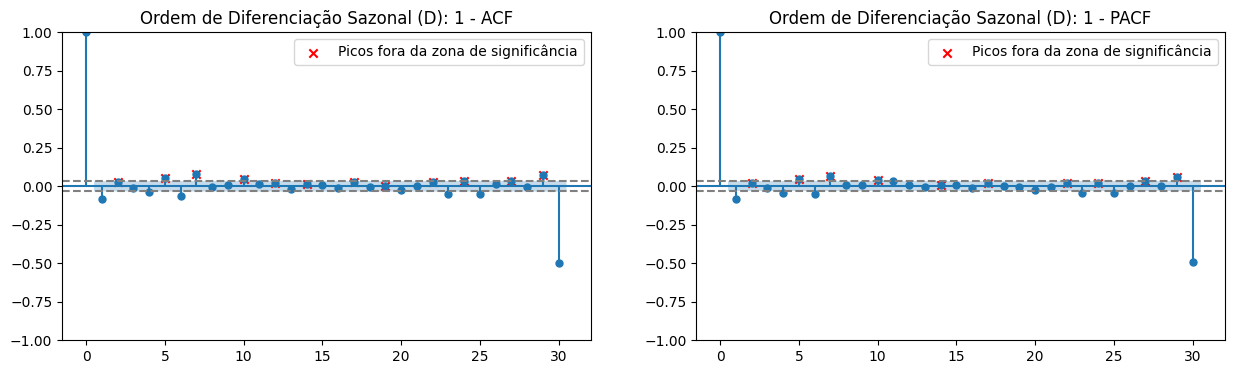

Ordem de Diferenciação Sazonal (D): 2, Pontos fora da zona de significância (ACF): 13
Ordem de Diferenciação Sazonal (D): 2, Pontos fora da zona de significância (PACF): 11


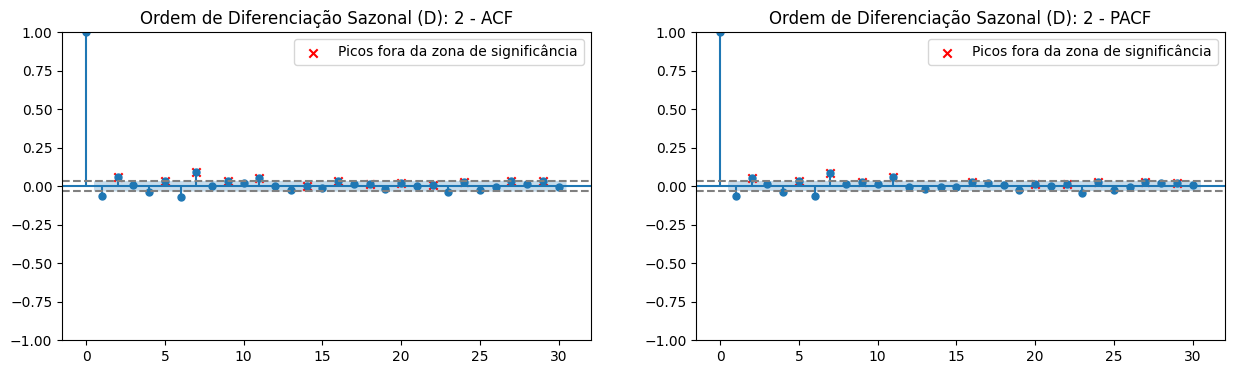

Ordem de Diferenciação Sazonal (D): 3, Pontos fora da zona de significância (ACF): 12
Ordem de Diferenciação Sazonal (D): 3, Pontos fora da zona de significância (PACF): 10


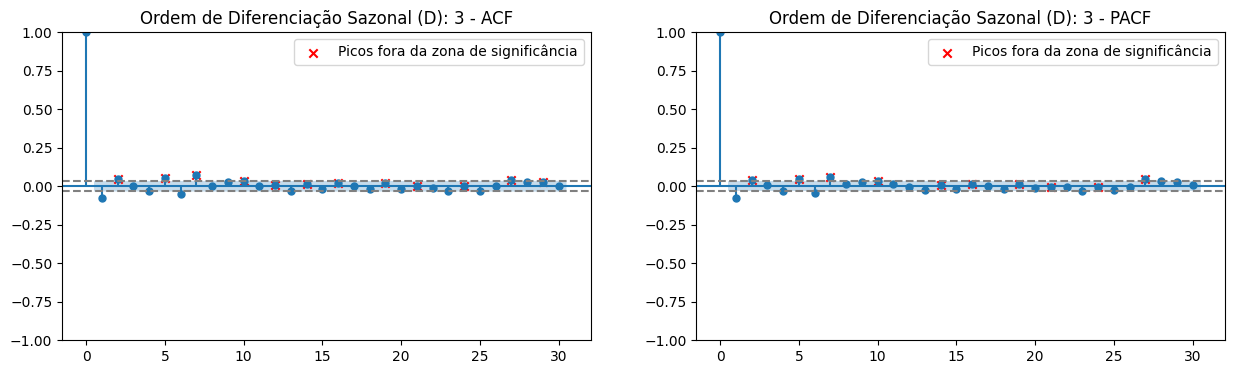

Ordem de Diferenciação Sazonal (D): 4, Pontos fora da zona de significância (ACF): 10
Ordem de Diferenciação Sazonal (D): 4, Pontos fora da zona de significância (PACF): 10


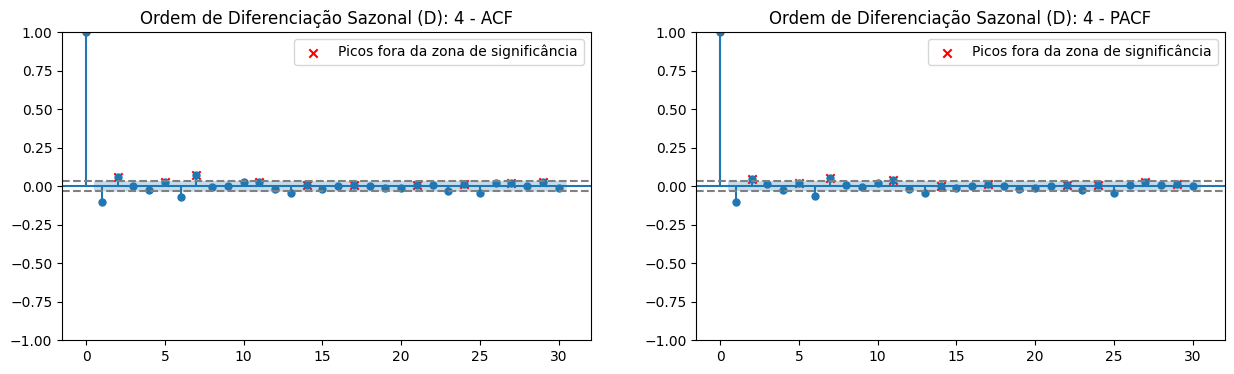

Ordem de Diferenciação Sazonal (D): 5, Pontos fora da zona de significância (ACF): 11
Ordem de Diferenciação Sazonal (D): 5, Pontos fora da zona de significância (PACF): 10


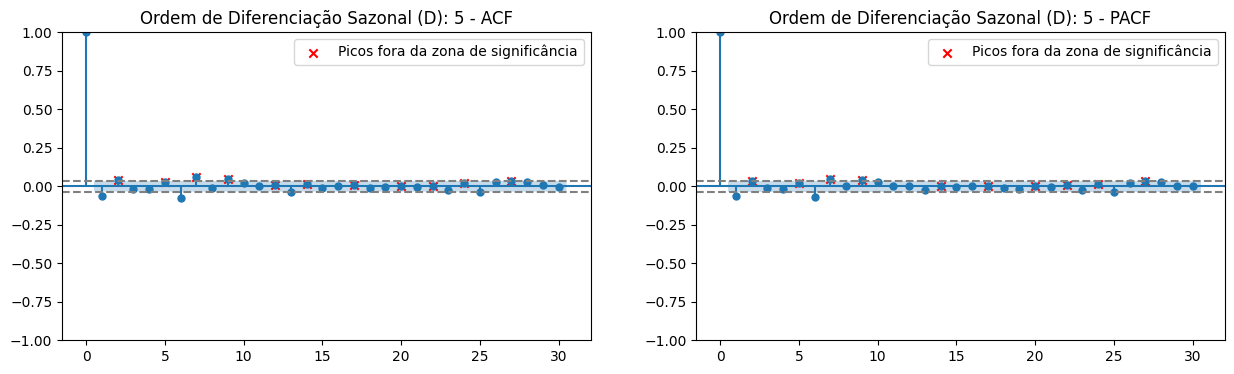

In [172]:
seasonal_lags = 30  # Ajuste conforme necessário


# Plote ACF e PACF para diferentes ordens de diferenciação sazonal
for D in range(1, 6):  # Teste ordens de 1 a 5, por exemplo
    diff_series = datasetLogDiffShifting.diff(D * seasonal_lags).dropna()

    # Plote ACF e PACF e obtenha os valores do ACF e PACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(diff_series, lags=seasonal_lags, ax=ax1)
    plot_pacf(diff_series, lags=seasonal_lags, ax=ax2)
    ax1.set_title(f'Ordem de Diferenciação Sazonal (D): {D} - ACF')
    ax2.set_title(f'Ordem de Diferenciação Sazonal (D): {D} - PACF')

    # Calcule os picos e limites de significância para ACF
    acf_values = np.squeeze(ax1.lines[1].get_ydata())  # Obtenha os valores do ACF
    picos_acf, _ = find_peaks(acf_values)
    limite_superior_acf = 1.96 / np.sqrt(len(diff_series))
    limite_inferior_acf = -1.96 / np.sqrt(len(diff_series))

    # Plote os picos fora da zona de significância para ACF
    ax1.scatter(picos_acf, acf_values[picos_acf], color='red', marker='x', label='Picos fora da zona de significância')
    ax1.axhline(y=limite_superior_acf, linestyle='--', color='gray')
    ax1.axhline(y=limite_inferior_acf, linestyle='--', color='gray')
    ax1.legend()

    # Calcule os picos e limites de significância para PACF
    pacf_values = np.squeeze(ax2.lines[1].get_ydata())  # Obtenha os valores do PACF
    picos_pacf, _ = find_peaks(pacf_values)
    limite_superior_pacf = 1.96 / np.sqrt(len(diff_series))
    limite_inferior_pacf = -1.96 / np.sqrt(len(diff_series))

    # Plote os picos fora da zona de significância para PACF
    ax2.scatter(picos_pacf, pacf_values[picos_pacf], color='red', marker='x', label='Picos fora da zona de significância')
    ax2.axhline(y=limite_superior_pacf, linestyle='--', color='gray')
    ax2.axhline(y=limite_inferior_pacf, linestyle='--', color='gray')
    ax2.legend()

    # Mostre quantos pontos estão fora da zona de significância para ACF e PACF
    pontos_fora_zona_acf = len(picos_acf)
    pontos_fora_zona_pacf = len(picos_pacf)
    print(f'Ordem de Diferenciação Sazonal (D): {D}, Pontos fora da zona de significância (ACF): {pontos_fora_zona_acf}')
    print(f'Ordem de Diferenciação Sazonal (D): {D}, Pontos fora da zona de significância (PACF): {pontos_fora_zona_pacf}')

    plt.show()

Ordem de Diferenciação Sazonal (D): 4: Isso significa que a série temporal foi diferenciada quatro vezes com um lag sazonal para torná-la estacionária.

Pontos fora da zona de significância (ACF): 10: No gráfico de Autocorrelação (ACF), foram identificados 10 lags que têm autocorrelação significativamente diferente de zero. Isso pode indicar a presença de padrões sazonais na série temporal.

Pontos fora da zona de significância (PACF): 10: No gráfico de Autocorrelação Parcial (PACF), também foram identificados 10 lags que têm autocorrelação parcial significativamente diferente de zero. Esses pontos indicam lags em que há uma correlação que não é explicada pelas correlações nos lags anteriores, sugerindo possível influência sazonal.

##### Definindo parametros de Sazonalidade - Q: Ordem MA sazonal.

Este parâmetro indica o número de lags no qual os erros de previsão são correlacionados sazonalmente. Em outras palavras, refere-se à quantidade de termos de média móvel que estão incluídos no modelo para explicar padrões sazonais

Escolhendo o melhor Q:

Escolher o valor adequado para a ordem MA sazonal (Q) envolve analisar os gráficos ACF (Função de Autocorrelação) e observar os pontos fora da zona de significância. Aqui estão algumas diretrizes que podem ajudar:

Identificar o Lag Sazonal: Observe se há lags sazonais significativos no gráfico ACF. Esses lags representam a sazonalidade na série temporal. A ordem MA sazonal (Q) deve ser escolhida com base na quantidade de lags significativos.

Número Mínimo de Lags Sazonais: Comece testando com um número pequeno de lags sazonais e observe como a autocorrelação se comporta. Aumente gradualmente o valor de Q e observe se há melhora na explicação da sazonalidade.

Evite Overfitting: Evite escolher um valor muito alto para Q, pois isso pode levar a um overfitting, onde o modelo se ajusta demais aos dados de treinamento e não generaliza bem para novos dados.

Validação Cruzada: Considere o uso de técnicas de validação cruzada, como dividir seus dados em conjuntos de treinamento e teste, para avaliar o desempenho do modelo com diferentes valores de Q.

Modelagem Iterativa: A escolha do valor adequado para Q muitas vezes é um processo iterativo. Você pode testar diferentes valores, ajustar o modelo e avaliar o desempenho até encontrar uma configuração que forneça bons resultados.

Ordem MA Sazonal (Q): 1, Pontos fora da zona de significância: 12


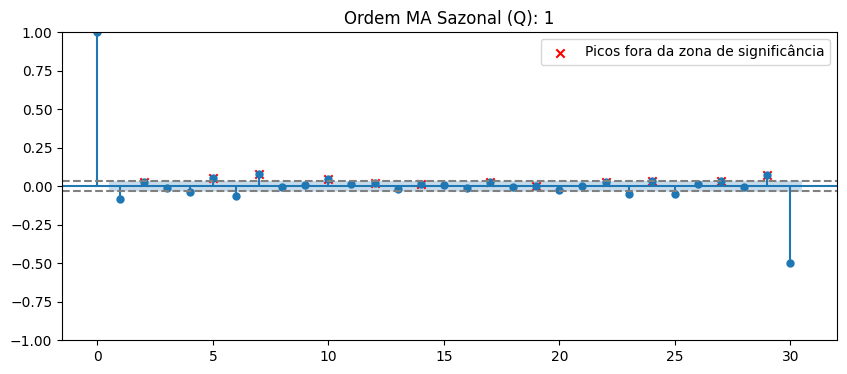

Ordem MA Sazonal (Q): 2, Pontos fora da zona de significância: 23


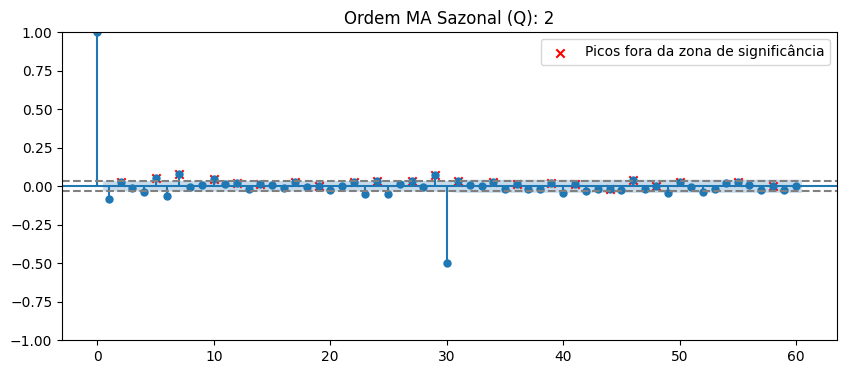

Ordem MA Sazonal (Q): 3, Pontos fora da zona de significância: 33


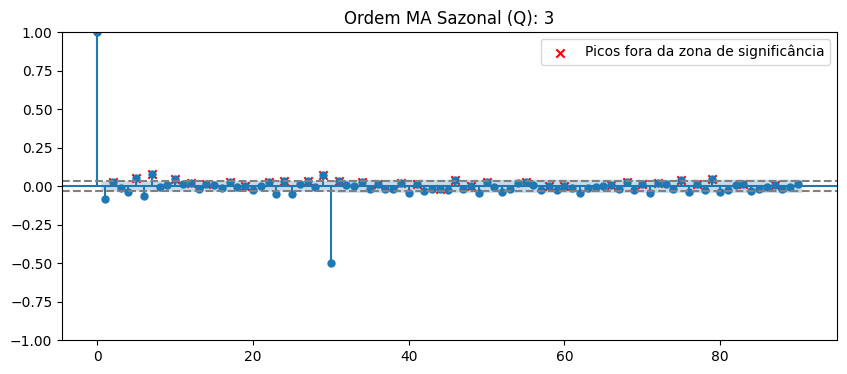

Ordem MA Sazonal (Q): 4, Pontos fora da zona de significância: 45


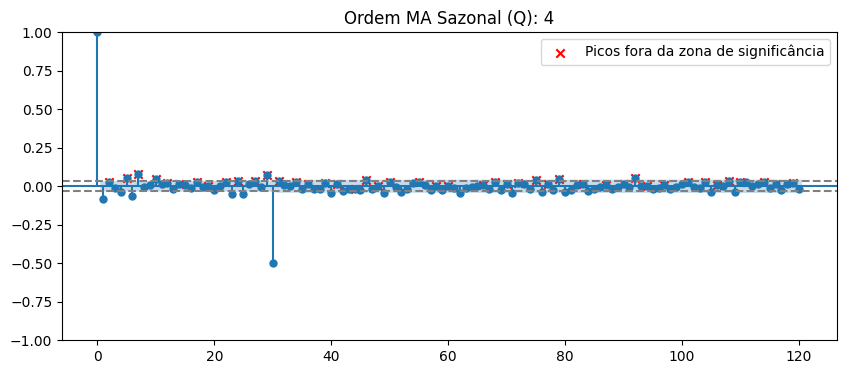

Ordem MA Sazonal (Q): 5, Pontos fora da zona de significância: 56


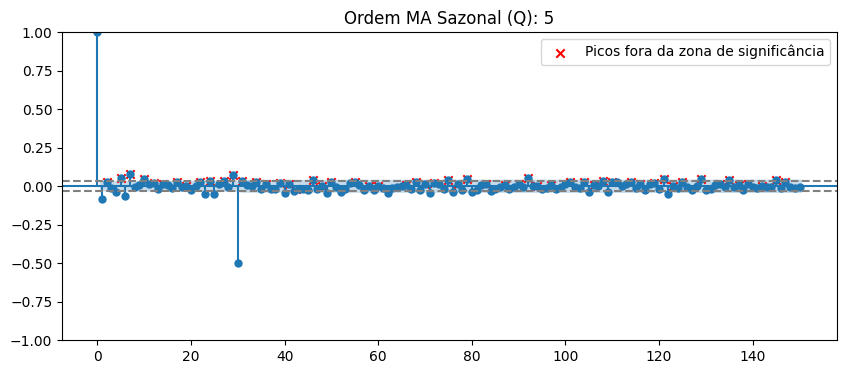

In [181]:
seasonal_lags = 30  # Ajuste conforme necessário

# Plote ACF para diferentes ordens MA sazonal (Q)
for Q in range(1, 6):  # Teste ordens de 1 a 5, por exemplo
    diff_series = datasetLogDiffShifting['Close'].diff(seasonal_lags).dropna()
    # Plote ACF e obtenha os valores do ACF
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(diff_series, lags=Q * seasonal_lags, ax=ax)
    ax.set_title(f'Ordem MA Sazonal (Q): {Q}')

    # Calcule os picos e limites de significância
    acf_values = np.squeeze(ax.lines[1].get_ydata())  # Obtenha os valores do ACF
    picos, _ = find_peaks(acf_values)
    limite_superior = 1.96 / np.sqrt(len(diff_series))
    limite_inferior = -1.96 / np.sqrt(len(diff_series))

    # Plote os picos fora da zona de significância
    ax.scatter(picos, acf_values[picos], color='red', marker='x', label='Picos fora da zona de significância')
    ax.axhline(y=limite_superior, linestyle='--', color='gray')
    ax.axhline(y=limite_inferior, linestyle='--', color='gray')
    ax.legend()

    # Mostre quantos pontos estão fora da zona de significância
    pontos_fora_zona = len(picos)
    print(f'Ordem MA Sazonal (Q): {Q}, Pontos fora da zona de significância: {pontos_fora_zona}')

    plt.show()

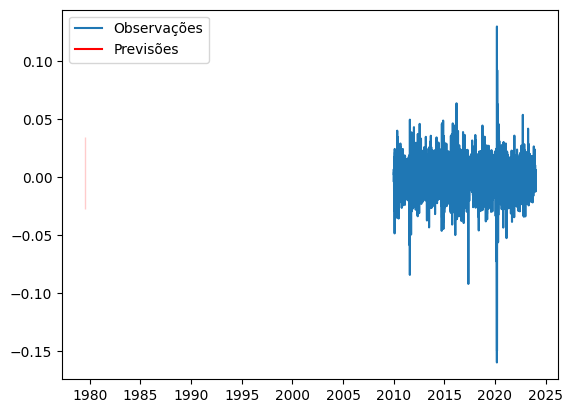

In [186]:
# Ajuste o modelo SARIMA
order = (1, 1, 1)  # Ordem (p, d, q) para a parte não sazonal
seasonal_order = (1, 2, 2, 30)  # Ordem (P, D, Q, s) para a parte sazonal
model = SARIMAX(datasetLogDiffShifting['Close'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Faça previsões passo a passo
forecast_steps = 30
for i in range(forecast_steps):
    forecast = results.get_forecast(steps=1)

# Obtenha os valores previstos e os intervalos de confiança
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Visualize os resultados
plt.plot(datasetLogDiffShifting['Close'], label='Observações')
plt.plot(forecast_values, label='Previsões', color='red')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.show()

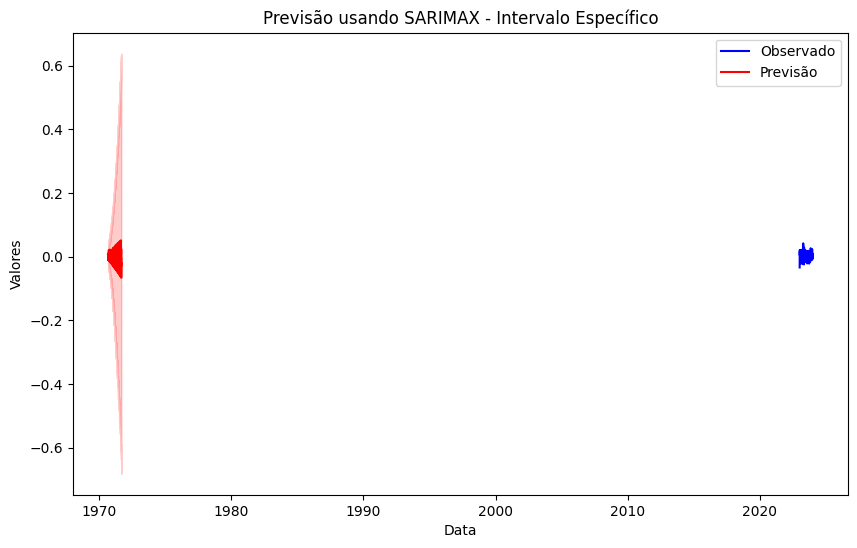

In [193]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Suponha que você tenha um DataFrame chamado datasetLogDiffShifting com uma coluna 'Close'
# Certifique-se de que datasetLogDiffShifting['Close'] seja uma série temporal com índice de datas

# Ajustar o intervalo de datas conforme necessário
start_date = '2023-01-01'
end_date = '2023-12-31'
datasetLogDiffShifting = datasetLogDiffShifting[start_date:end_date]

# Configurar o modelo SARIMAX
order = (1, 1, 1)  # Ordem (p, d, q) para a parte não sazonal
seasonal_order = (1, 2, 2, 30)  # Ordem (P, D, Q, s) para a parte sazonal
model = SARIMAX(datasetLogDiffShifting['Close'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Fazer previsões
forecast_steps = 365  # Número de passos à frente para prever (um ano, por exemplo)
forecast = results.get_forecast(steps=forecast_steps)

# Obter os valores previstos
forecast_values = forecast.predicted_mean

# Visualizar os resultados apenas para o intervalo específico
# Visualizar os resultados apenas para o intervalo específico
plt.figure(figsize=(10, 6))
plt.plot(datasetLogDiffShifting['Close'], label='Observado', color='blue')
plt.plot(forecast_values.index, forecast_values.values, label='Previsão', color='red')
plt.fill_between(forecast_values.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

plt.title('Previsão usando SARIMAX - Intervalo Específico')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()